<img src="img/mCIDaeNnb.png" alt="Logo CiDAEN" align="right">



<br><br><br>
<h2><font color="#00586D" size=4>Module 7</font></h2>



<h1><font color="#00586D" size=5>Capstone 7. Part 1: Ingesting electricity demand data into InfluxDB</font></h1>

<br><br><br>
<div style="text-align: right">
<font color="#00586D" size=3>Enrique González, Luis de la Ossa</font><br>
<font color="#00586D" size=3>Master in Data Science and Data Engineering in the Cloud III </font><br>
<font color="#00586D" size=3>University of Castilla-La Mancha</font>

</div>

---

<a id="indice"></a>
<h2><font color="#00586D" size=5>Index</font></h2>


*[1. Introduction](#section1)* [2. Energy demand data extraction](#section2)
* [3. Ingestion and viewing](#section3)

In [1]:
import matplotlib.pyplot as plt

# Optimiza los gráficos para pantalla retina
%config InlineBackend.figure_format = 'retina'
# Por defecto usamos el backend inline
%matplotlib inline

# Oculta warnings
import warnings
warnings.simplefilter('ignore')

# La libreta ocupa así el 95% de la pantalla
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

---

<a id="section1"></a>
## <font color="#00586D"> 1. Introduction</font>
<br>

In this Capstone you will put yourself in the shoes of a _data scientist_ ​​who aims to prototype a visualization and forecasting system for Spanish hourly energy demand. This prototype will include the following functionalities:
- **Extraction of electricity demand data from Red Eléctrica**. The peninsular demand data must be extracted from the Electrical Network system that is freely available through its data API.
- **Continuous data ingestion to InfluxDB**. The extracted and processed data will be ingested into InfluxDB on a continuous basis with the objective of being able to visualize the real demand as well as various metrics obtained from this series.
- **Creation of a demand data forecasting model**. You will create a simple forecast model for the next day with the demand data previously ingested into the database.
- **Forecast intake in the database**. The forecast will also be ingested into the database, to be able to view the result along with the rest of the information.

This Capstone has been divided into two parts to separate the data extraction and ingestion part from the forecasting part. It is recommended to complete this first part to a large extent since you will need data already ingested into the database to be able to do the second.

Below we include some imports that you will need to complete the rest of the work. You can include those that you see necessary.

In [2]:
import requests
import json
import pandas as pd
import datetime
import uuid
import pickle
import time

from influxdb_client import InfluxDBClient, Point, WritePrecision
from influxdb_client.client.write_api import SYNCHRONOUS

---

<a id="section2"></a>
## <font color="#00586D"> 2. Energy demand data extraction</font>
<br>

The peninsular energy demand data is available through the Red Eléctrica Española page, [REDData](https://www.ree.es/es/apidatos). Through this page, Red Eléctrica offers free of charge a large amount of information not only on demand but also on other topics related to generation, electricity balance, markets, etc.

In the case of demand, Red Eléctrica offers a REST-type API that contains updated demand data (in MW) up to the current moment in 10-minute intervals. We will use this API to download all data (both historical and current) for the demand.

First of all, let's see what types of data this API includes. For its use, no type of authentication is necessary, but we can simply make a GET request to the _endpoint_ of the API, which will return the requested data. Let's look at an example.

In [3]:
import requests
import json

r = requests.get('https://apidatos.ree.es/en/datos/demanda/demanda-tiempo-real?start_date=2023-02-19T00:00&end_date=2023-02-19T23:59&time_trunc=hour')

r.json()

{'data': {'type': 'Demanda peninsular en tiempo real',
  'id': 'dem15',
  'attributes': {'title': 'Demanda peninsular en tiempo real',
   'last-update': '2023-02-20T00:04:00.000+01:00',
   'description': None},
  'meta': {'cache-control': {'cache': 'MISS'}}},
 'included': [{'type': 'Real demand',
   'id': '1293',
   'groupId': None,
   'attributes': {'title': 'Real demand',
    'description': 'Real demand',
    'color': '#ffea00',
    'type': None,
    'magnitude': None,
    'composite': False,
    'last-update': '2023-02-20T00:04:00.000+01:00',
    'values': [{'value': 24309,
      'percentage': 0.3330775660085225,
      'datetime': '2023-02-19T00:00:00.000+01:00'},
     {'value': 24371,
      'percentage': 0.3340460819386762,
      'datetime': '2023-02-19T00:05:00.000+01:00'},
     {'value': 24337,
      'percentage': 0.33429026675091345,
      'datetime': '2023-02-19T00:10:00.000+01:00'},
     {'value': 24217,
      'percentage': 0.33621647137224414,
      'datetime': '2023-02-19T00

As you can see, using the API is quite simple. Next we will describe the main fields of both the request and the response. The _url_ to make requests for energy demand is the following:

```
https://apidatos.ree.es/en/datos/demanda/demanda-tiempo-real
```

It is necessary to pass a series of parameters to this URL to define what series of data we want to obtain. The parameters are as follows:
- `start_date`: The start date and time of the data we want to obtain. It has the format `YYYY-MM-DDTHH:MM`.
- `end_date`: The end date and time of the data to be obtained. Follows the same format as `start_date`
- `time_trunc`: The data aggregation format. It supports several formats, although we will choose `hour`.

As for the API response, you can see that it is a json that provides us in periods of 10 minutes with (among other information):
- Instantaneous demand (in MW)
- The demand forecasted by REE (in MW)
- Scheduled demand (in MW)

You can consult more information about this API at [API page](https://www.ree.es/es/apidatos).

For this work, we are only interested in the first two, since in this way we will be able to compare the model we have obtained with the forecast model made by Red Eléctrica. Therefore, the first thing will be to extract this data and process it correctly to be able to include it in InfluxDB. It is relatively simple to model this time series data in the database:
- Our measure will be the demand: `demand`.
- Under this, we will not include any additional tags.
- We will use two fields, one for real demand (`RealDemand`) and another for forecast (`ForecastREE`).

However, until we reach this point, we will have to implement some functions that allow us to both process and write data to InfluxDB.


--- 

### <font color="#004D7F"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#004D7F"></i> Task 1</font>
<br>

Given the results of the API (of which you can take the previous result as an example), implement the following function that takes the response from the API and converts it into a DataFrame with the following characteristics:
- It must be a DataFrame with the following columns: `RealDemand` (with the real demand of the API) and `ForecastREE` (with the REE Forecast).
- The DataFrame must have a temporary index. We recommend using timestamps in UTC in order to have fewer problems (time changes, etc.)
- The frequency of the data must be hourly (you must add by the average)

For now, don't worry about how to obtain the data, we simply want to process it.

_Hint_: For this processing, the first practices on time series analysis will be useful.

In [10]:
def process_response(json_response: dict) -> pd.DataFrame:
    """
    Crea un dataframe a partir de la respuesta json. 
    """
    dataframe = []
    
    for i in range(len(json_response["included"])):
        
        data = pd.json_normalize(
            
            json_response["included"][i]["attributes"]["values"])[["value","datetime"]].rename(
            columns={"value": json_response["included"][i]["attributes"]["title"]}
            
        )
        
        data["datetime"] = pd.to_datetime(data["datetime"], format='%Y-%m-%d %H:%M:%S',utc=True).dt.tz_localize(None)
        
    
        dataframe.append(data)
    final_df = pd.merge(dataframe[0], dataframe[2], how='inner').resample(rule='H', on='datetime').mean()
    #final_df = pd.concat(dataframe).resample(rule='H', on='datetime').mean().drop("Programmed demand")
    final_df.index = final_df.index.strftime('%Y-%m-%d %H:%M:%S')
    final_df.columns = final_df.columns.str.title().str.replace(" ","")
       
    return final_df

In [11]:
result = process_response(r.json())
result

,RealDemand,ForecastDemand
datetime,,
2023-02-18 23:00:00,23709.166667,23799.833333
2023-02-19 00:00:00,22150.000000,22076.333333
2023-02-19 01:00:00,20940.083333,20941.166667
2023-02-19 02:00:00,20202.000000,20349.500000
2023-02-19 03:00:00,19905.250000,19983.583333
2023-02-19 04:00:00,19929.250000,19959.666667
2023-02-19 05:00:00,20429.583333,20499.916667
2023-02-19 06:00:00,21052.833333,21164.750000
2023-02-19 07:00:00,21556.750000,21523.666667


<div style="text-align: right"><font size=4> <i class="fa fa-check-square-o" aria-hidden="true" style="color:#00586D"></i></font></div>

--- 

Our ultimate goal with this data is to be able to continuously ingest it into the InfluxDB database. With the processing of the previous task, we obtain data in a format that is useful for both analysis and data ingestion into InfluxDB, since, if you remember from the practice we did with the database, it was possible to ingest data directly from a DataFrame. The next step will, therefore, be to facilitate the writing to InfluxDB of the data that we have processed in the previous task to InfluxDB.


--- 

### <font color="#004D7F"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#004D7F"></i> Task 2</font>
<br>

Implement the following function that ingests a dataframe like the one you processed in the previous exercise in InfluxDB. To do this, use a bucket called `capstone7`, which you must create previously.

With this you can now use the access information to write the DataFrame. Indicate as a measure `demand`, which will have two fields, the real demand (`RealDemand`) and the demand predicted by Red Eléctrica (`ForecastDemand`).

Once the function is implemented, we recommend that you execute the code provided to ingest the data and **include a capture of the data in graphic format such as the one given as an example along with the notebook**. Pay close attention to the time range on the InfluxDB platform that matches the data you are ingesting.

_Hint_: To carry out this task, the practice on ingestion in InfluxDB in this module will be very useful.

In [12]:
result

,RealDemand,ForecastDemand
datetime,,
2023-02-18 23:00:00,23709.166667,23799.833333
2023-02-19 00:00:00,22150.000000,22076.333333
2023-02-19 01:00:00,20940.083333,20941.166667
2023-02-19 02:00:00,20202.000000,20349.500000
2023-02-19 03:00:00,19905.250000,19983.583333
2023-02-19 04:00:00,19929.250000,19959.666667
2023-02-19 05:00:00,20429.583333,20499.916667
2023-02-19 06:00:00,21052.833333,21164.750000
2023-02-19 07:00:00,21556.750000,21523.666667


In [13]:
# Podéis incluir la información de vuestra instancia de InfluxDB a continuación
token = "mcidaen_token"
org = "mcidaen"
bucket = "capstone7"

client = InfluxDBClient(url="http://influxdb:8086", token=token)

In [17]:
def save_to_influxdb(df: pd.DataFrame, client: InfluxDBClient, bucket: str, org: str) -> pd.DataFrame:
    """
    Escribe el DataFrame en InfluxDB
    """
    
    
    write_api = client.write_api(write_options=SYNCHRONOUS)
    write_api.write(bucket, org, record=df, data_frame_measurement_name='demand', data_frame_tag_columns=["Real demand","Forecast demand"])

In [18]:
save_to_influxdb(result, client, bucket, org)

Establishing the time range from 02/18/2023 22:00 - 02/19/2023 23:00 the graph obtained is:
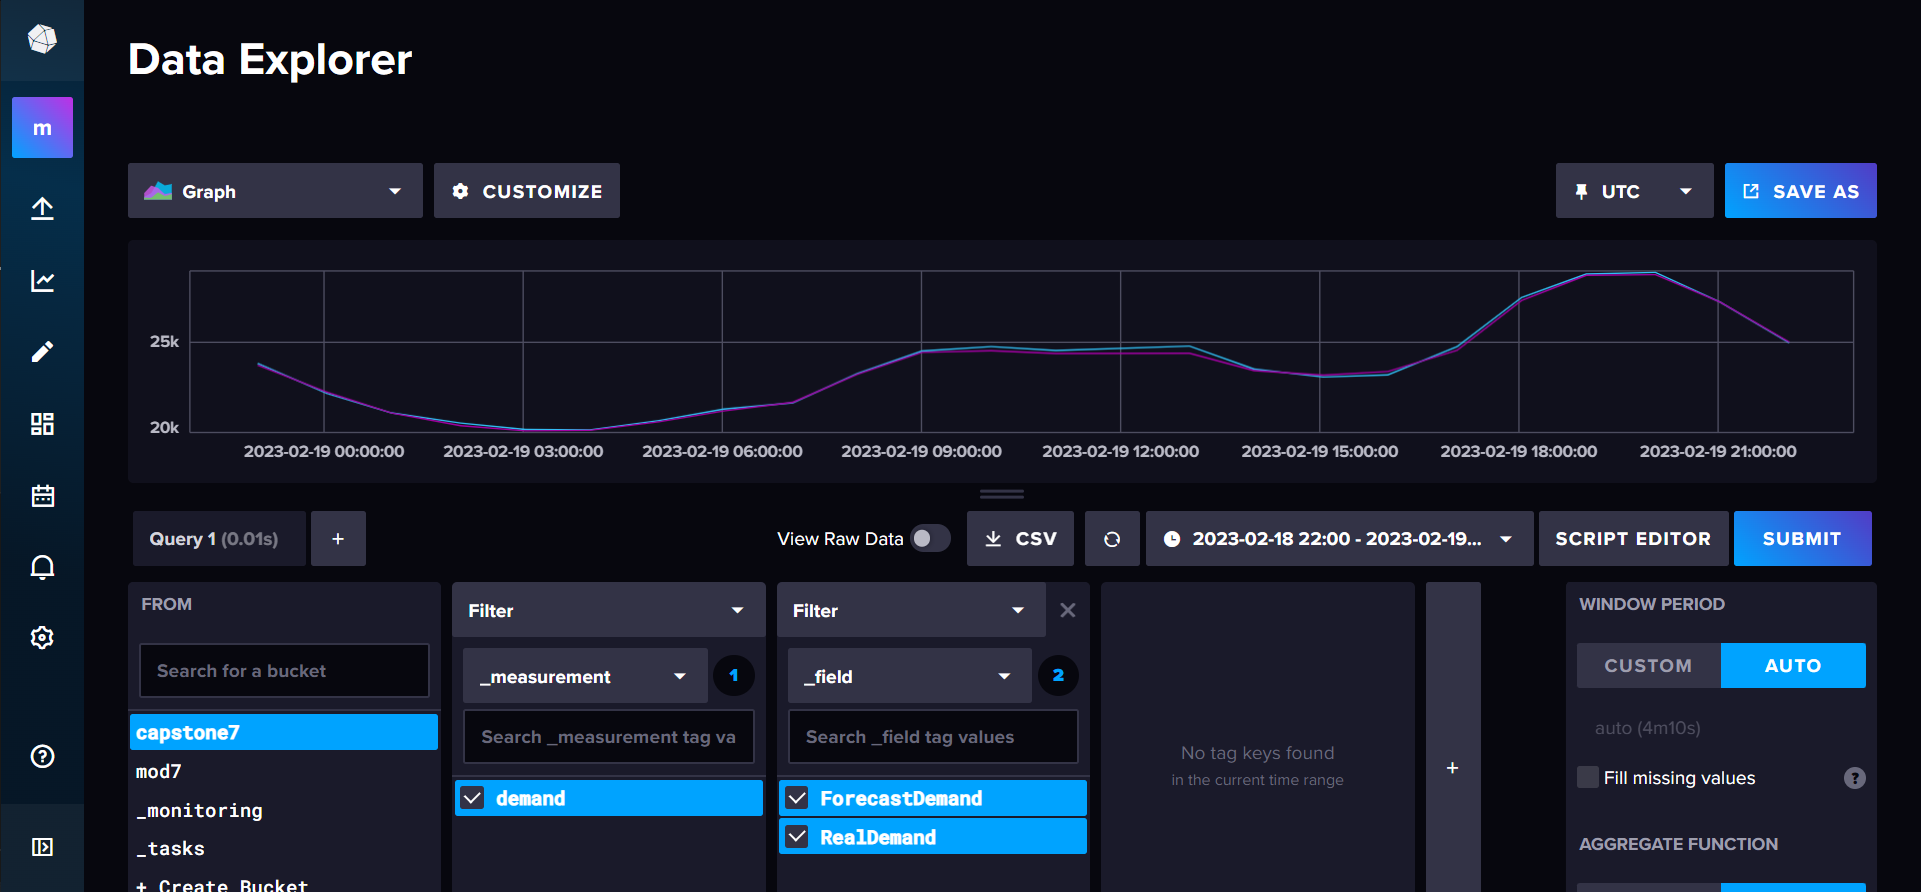
We make sure that the time is in UTC:
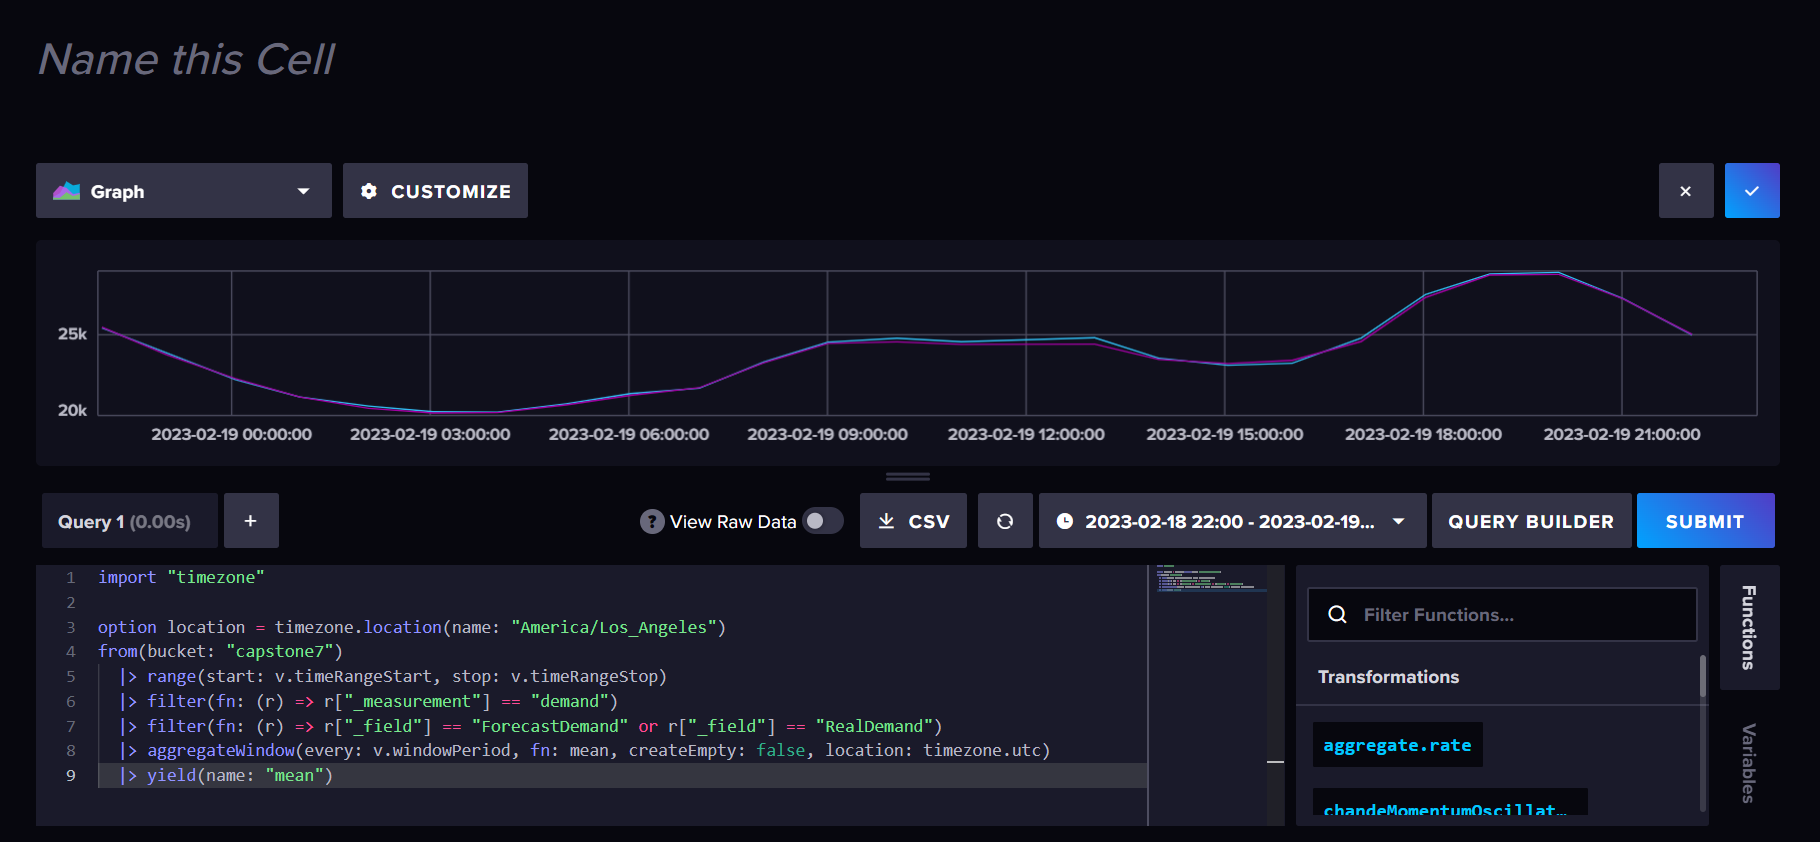
(Explanation) To carry out this exercise, what we do is create a bucket with the name capstone7 to which we add data using the "configure a telegraf agent" option, to which we must modify the url and token:
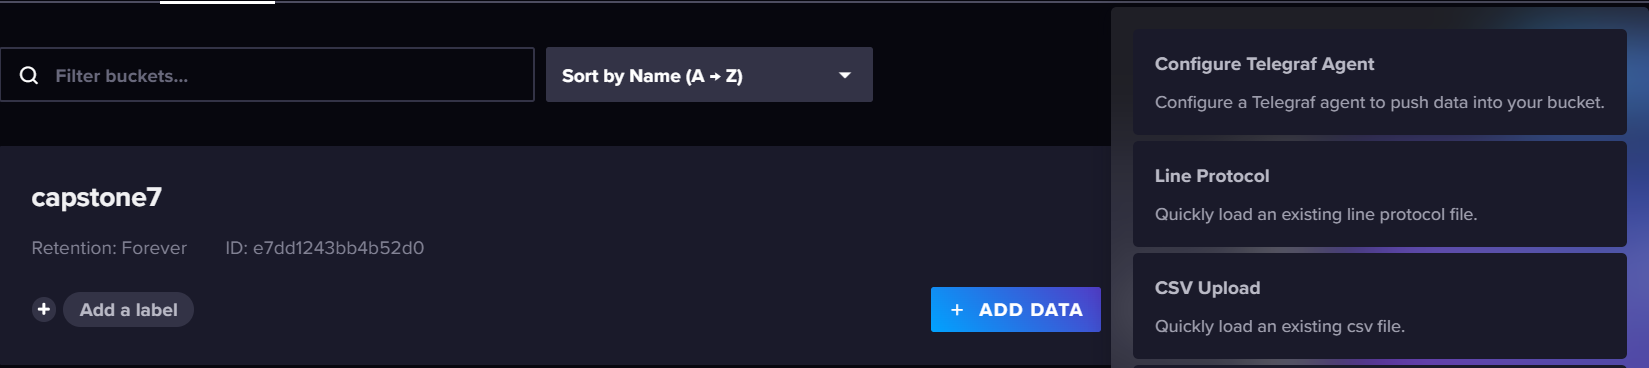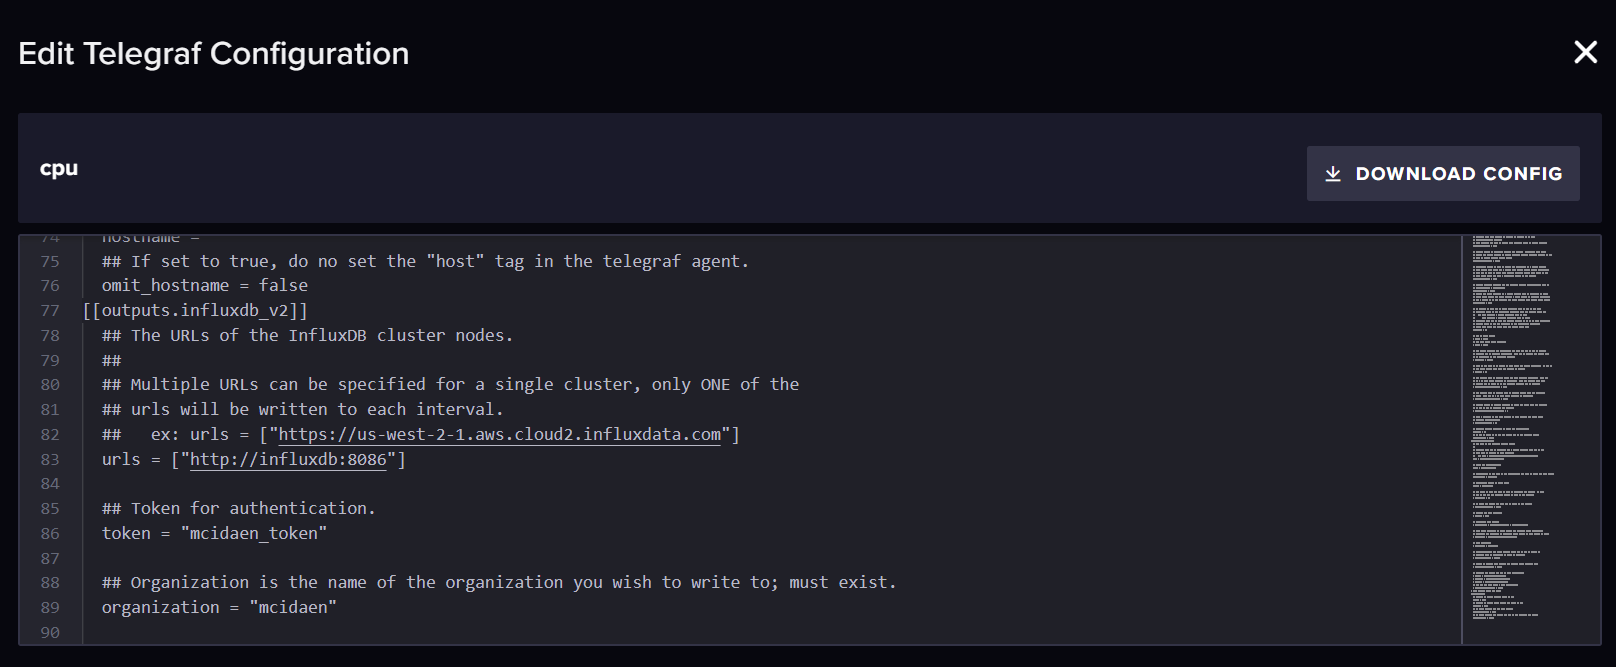

<div style="text-align: right"><font size=4> <i class="fa fa-check-square-o" aria-hidden="true" style="color:#00586D"></i></font></div>

--- 

With the two functions above, we now have the ability to both process the results from the API and ingest the data into our InfluxDB instance. However, we have not yet implemented any function for requesting data from the Red Eléctrica API. You are going to do this next.


--- 

### <font color="#004D7F"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#004D7F"></i> Task 3</font>
<br>

Implement the following function that will get the data from the API for a given period of time between `begin` and `end`, both of type `datetime`. It will return the `json` object that we parsed with the function in the first exercise. You do not need to parse the response beyond converting it into a `json` object.

_Optional_: As a recommendation at this point, and to avoid possible failures in the requests, you can implement a separate retry logic using a _sleep_ and capturing, for example, request.RequestException or some of your [subexceptions](https://requests.readthedocs.io/en/master/_modules/requests/exceptions/)

In [19]:
def get_demand_data(begin: datetime.datetime, end: datetime.datetime) -> dict:
    """
    Obtiene los datos de demanda entre begin y end
    """
    
    r = requests.get(f'https://apidatos.ree.es/en/datos/demanda/demanda-tiempo-real?start_date={begin}&end_date={end}&time_trunc=hour')

    return r.json()

In [20]:
result = get_demand_data(
    datetime.datetime(2023, 2, 10),
    datetime.datetime(2023, 2, 10, 23, 59)
)

In [21]:
result

{'data': {'type': 'Demanda peninsular en tiempo real',
  'id': 'dem15',
  'attributes': {'title': 'Demanda peninsular en tiempo real',
   'last-update': '2023-02-11T00:04:00.000+01:00',
   'description': None},
  'meta': {'cache-control': {'cache': 'MISS'}}},
 'included': [{'type': 'Real demand',
   'id': '1293',
   'groupId': None,
   'attributes': {'title': 'Real demand',
    'description': 'Real demand',
    'color': '#ffea00',
    'type': None,
    'magnitude': None,
    'composite': False,
    'last-update': '2023-02-11T00:04:00.000+01:00',
    'values': [{'value': 27591,
      'percentage': 0.3305578185651986,
      'datetime': '2023-02-10T00:00:00.000+01:00'},
     {'value': 27850,
      'percentage': 0.3331220171524945,
      'datetime': '2023-02-10T00:05:00.000+01:00'},
     {'value': 27925,
      'percentage': 0.3343030215965139,
      'datetime': '2023-02-10T00:10:00.000+01:00'},
     {'value': 27862,
      'percentage': 0.3343172546196304,
      'datetime': '2023-02-10T00:1

In [22]:
process_response(result)

,RealDemand,ForecastDemand
datetime,,
2023-02-09 23:00:00,27342.166667,27348.333333
2023-02-10 00:00:00,25742.583333,25497.500000
2023-02-10 01:00:00,24570.666667,24416.250000
2023-02-10 02:00:00,24028.833333,23943.833333
2023-02-10 03:00:00,23989.583333,23924.583333
2023-02-10 04:00:00,24810.333333,24531.000000
2023-02-10 05:00:00,27752.000000,27487.250000
2023-02-10 06:00:00,32448.416667,32457.000000
2023-02-10 07:00:00,34902.833333,35021.166667


<div style="text-align: right"><font size=4> <i class="fa fa-check-square-o" aria-hidden="true" style="color:#00586D"></i></font></div>

--- 

With these three functions, we already have what is necessary to extract data from the API. In the next section you will implement the complete ingestion logic.

---

<a id="section3"></a>
## <font color="#00586D"> 3. Data ingestion and visualization. </font>
<br>

With the aim of carrying out a relatively robust ingestion process that allows us to ingest robustly even in the face of small failures, we are going to use a list of days already processed and an extraction and ingestion process that takes into account the values ​​already processed .

Actually, for our case, since we use InfluxDB, we can safely restart the ingestion as many times as we want, since the old data will be overwritten (and the value should be the same). However, as we intend to download a considerable amount of data, it is not advisable to do the complete ingestion repeatedly. To avoid re-processing days, we will maintain a set with the days already ingested and create a logic that takes this set into account and is limited to re-ingesting data from one day to the current moment.

We can execute this logic repeatedly, so that, as long as we keep this set of ingested days updated, no additional processing will be carried out (except in the case of the last day).

To carry out the ingestion process, the following implemented function is provided to you. This takes as a parameter the start from which we want to download data `begin_ts` and a set with the days that have already been previously downloaded, `ingested`. The objective of the function is to ingest all the days that are not in InfluxDB from the initial date to the current moment and return the list of days (datetime) that have been ingested. The feature performs daily downloads (the API has a limit of points that can be downloaded). Of course, you can modify (and improve) this function if you think necessary.

In [23]:
def ingest_data(begin_ts: datetime.datetime, ingested: set) -> list:
    """
    Obtiene los datos de demanda desde begin_ts
    """
    
    now = datetime.datetime.now()
    end_ts = datetime.datetime(now.year, now.month, now.day, now.hour, 0) - datetime.timedelta(seconds=1)
    begin = begin_ts
    end = min(begin + datetime.timedelta(days=1, minutes=-1), end_ts)
    l = []
    df_l = []
    try:
        while begin < end_ts:
            if begin not in ingested:
                print(f"Getting data for: {begin} ----> {end}")
                r = get_demand_data(begin, end)
                df = process_response(r)
                save_to_influxdb(df, client, bucket, org)
                l.append(begin)
            begin += datetime.timedelta(days=1)
            end = min(begin + datetime.timedelta(days=1, minutes=-1), end_ts)
    except Exception as e:
        print(f"An exception occurred: {e}")
        return l
    return l

In [24]:
ingest_data(datetime.datetime(2023, 2, 24), set([]))

Getting data for: 2023-02-24 00:00:00 ----> 2023-02-24 23:59:00
Getting data for: 2023-02-25 00:00:00 ----> 2023-02-25 23:59:00
Getting data for: 2023-02-26 00:00:00 ----> 2023-02-26 23:59:00
Getting data for: 2023-02-27 00:00:00 ----> 2023-02-27 23:59:00
Getting data for: 2023-02-28 00:00:00 ----> 2023-02-28 23:59:00
Getting data for: 2023-03-01 00:00:00 ----> 2023-03-01 23:59:00
Getting data for: 2023-03-02 00:00:00 ----> 2023-03-02 23:59:00
Getting data for: 2023-03-03 00:00:00 ----> 2023-03-03 23:59:00
Getting data for: 2023-03-04 00:00:00 ----> 2023-03-04 23:59:00
Getting data for: 2023-03-05 00:00:00 ----> 2023-03-05 23:59:00
Getting data for: 2023-03-06 00:00:00 ----> 2023-03-06 23:59:00
Getting data for: 2023-03-07 00:00:00 ----> 2023-03-07 23:59:00
Getting data for: 2023-03-08 00:00:00 ----> 2023-03-08 23:59:00
Getting data for: 2023-03-09 00:00:00 ----> 2023-03-09 23:59:00
Getting data for: 2023-03-10 00:00:00 ----> 2023-03-10 23:59:00
Getting data for: 2023-03-11 00:00:00 --

[datetime.datetime(2023, 2, 24, 0, 0),
 datetime.datetime(2023, 2, 25, 0, 0),
 datetime.datetime(2023, 2, 26, 0, 0),
 datetime.datetime(2023, 2, 27, 0, 0),
 datetime.datetime(2023, 2, 28, 0, 0),
 datetime.datetime(2023, 3, 1, 0, 0),
 datetime.datetime(2023, 3, 2, 0, 0),
 datetime.datetime(2023, 3, 3, 0, 0),
 datetime.datetime(2023, 3, 4, 0, 0),
 datetime.datetime(2023, 3, 5, 0, 0),
 datetime.datetime(2023, 3, 6, 0, 0),
 datetime.datetime(2023, 3, 7, 0, 0),
 datetime.datetime(2023, 3, 8, 0, 0),
 datetime.datetime(2023, 3, 9, 0, 0),
 datetime.datetime(2023, 3, 10, 0, 0),
 datetime.datetime(2023, 3, 11, 0, 0),
 datetime.datetime(2023, 3, 12, 0, 0),
 datetime.datetime(2023, 3, 13, 0, 0),
 datetime.datetime(2023, 3, 14, 0, 0),
 datetime.datetime(2023, 3, 15, 0, 0),
 datetime.datetime(2023, 3, 16, 0, 0),
 datetime.datetime(2023, 3, 17, 0, 0),
 datetime.datetime(2023, 3, 18, 0, 0),
 datetime.datetime(2023, 3, 19, 0, 0),
 datetime.datetime(2023, 3, 20, 0, 0),
 datetime.datetime(2023, 3, 21, 0,

With the previous function we can now have a process running continuously that makes sure to download the data that we are missing in our dataset. In this case we have chosen to keep the already processed data set as a file (using `pickle`). In this set we will include all the processed data except for the last day, which will be incomplete and which we will have to continue downloading to continue updating the data in our database.

First of all, you will need to initialize the set of ingested days with the following cell. What we do is create an empty set and save it in the `ingested.db` file. We will then update this file as we process new days. We recommend that you comment on the cell once it has been initialized to avoid mistakenly deleting the data that you have processed so far.

In [25]:
import pickle
ingested_file = 'ingested.db'
ingested = set([])
with open(ingested_file, 'wb') as f:
    pickle.dump(ingested, f)

Using this, we simply repeat the previous operation every so often to update the data we have in InfluxDB. You can modify the start date if you want if at any time you encounter a problem in the intake or if you want to have more historical data to train the forecast model of the second part.

In [26]:
begin_ts = datetime.datetime(2022, 1, 1, 0, 0)
Now = datetime.datetime(datetime.datetime.now().year, datetime.datetime.now().month, datetime.datetime.now().day, 0, 0)

In [27]:

while True:
    with open(ingested_file, 'rb') as f:
        ingested = pickle.load(f)
    l = ingest_data(begin_ts, ingested)[:-1] # Remove last day to keep updating it
    ingested = ingested.union(set(l))
    with open(ingested_file, 'wb') as f:
        pickle.dump(ingested, f)
    print("Ingestion finished, sleeping for 10 seconds")
    time.sleep(60)
    
    

Getting data for: 2022-01-01 00:00:00 ----> 2022-01-01 23:59:00
Getting data for: 2022-01-02 00:00:00 ----> 2022-01-02 23:59:00
Getting data for: 2022-01-03 00:00:00 ----> 2022-01-03 23:59:00
Getting data for: 2022-01-04 00:00:00 ----> 2022-01-04 23:59:00
Getting data for: 2022-01-05 00:00:00 ----> 2022-01-05 23:59:00
Getting data for: 2022-01-06 00:00:00 ----> 2022-01-06 23:59:00
Getting data for: 2022-01-07 00:00:00 ----> 2022-01-07 23:59:00
Getting data for: 2022-01-08 00:00:00 ----> 2022-01-08 23:59:00
Getting data for: 2022-01-09 00:00:00 ----> 2022-01-09 23:59:00
Getting data for: 2022-01-10 00:00:00 ----> 2022-01-10 23:59:00
Getting data for: 2022-01-11 00:00:00 ----> 2022-01-11 23:59:00
Getting data for: 2022-01-12 00:00:00 ----> 2022-01-12 23:59:00
Getting data for: 2022-01-13 00:00:00 ----> 2022-01-13 23:59:00
Getting data for: 2022-01-14 00:00:00 ----> 2022-01-14 23:59:00
Getting data for: 2022-01-15 00:00:00 ----> 2022-01-15 23:59:00
Getting data for: 2022-01-16 00:00:00 --

KeyboardInterrupt: 

This process will take some time (possibly up to 1 hour). Meanwhile you can check in your InfluxDB instance that all the data is arriving correctly. Likewise, you can develop the next task or even the next part of the capstone.

### <font color="#004D7F"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#004D7F"></i> Task 4</font>
<br>

With the electricity demand data that you have already ingested (or are in the process of ingesting), create a dashboard with the following cells:
- A Graph type cell with the graphed data from RealDemand and ForecastDemand.
- A table-type cell with three columns: time, RealDemand and ForecastDemand. In order to obtain it you will need to use Flux and the pivot method.
- A Gauge type cell with the difference between RealDemand and ForecastDemand

All these metrics have to be calculated based on the time filter applied in the dashboard

**Include a screenshot of the Dashboard (including the image file with the delivery) made as well as the flux queries of the three tables**.

Dashboard: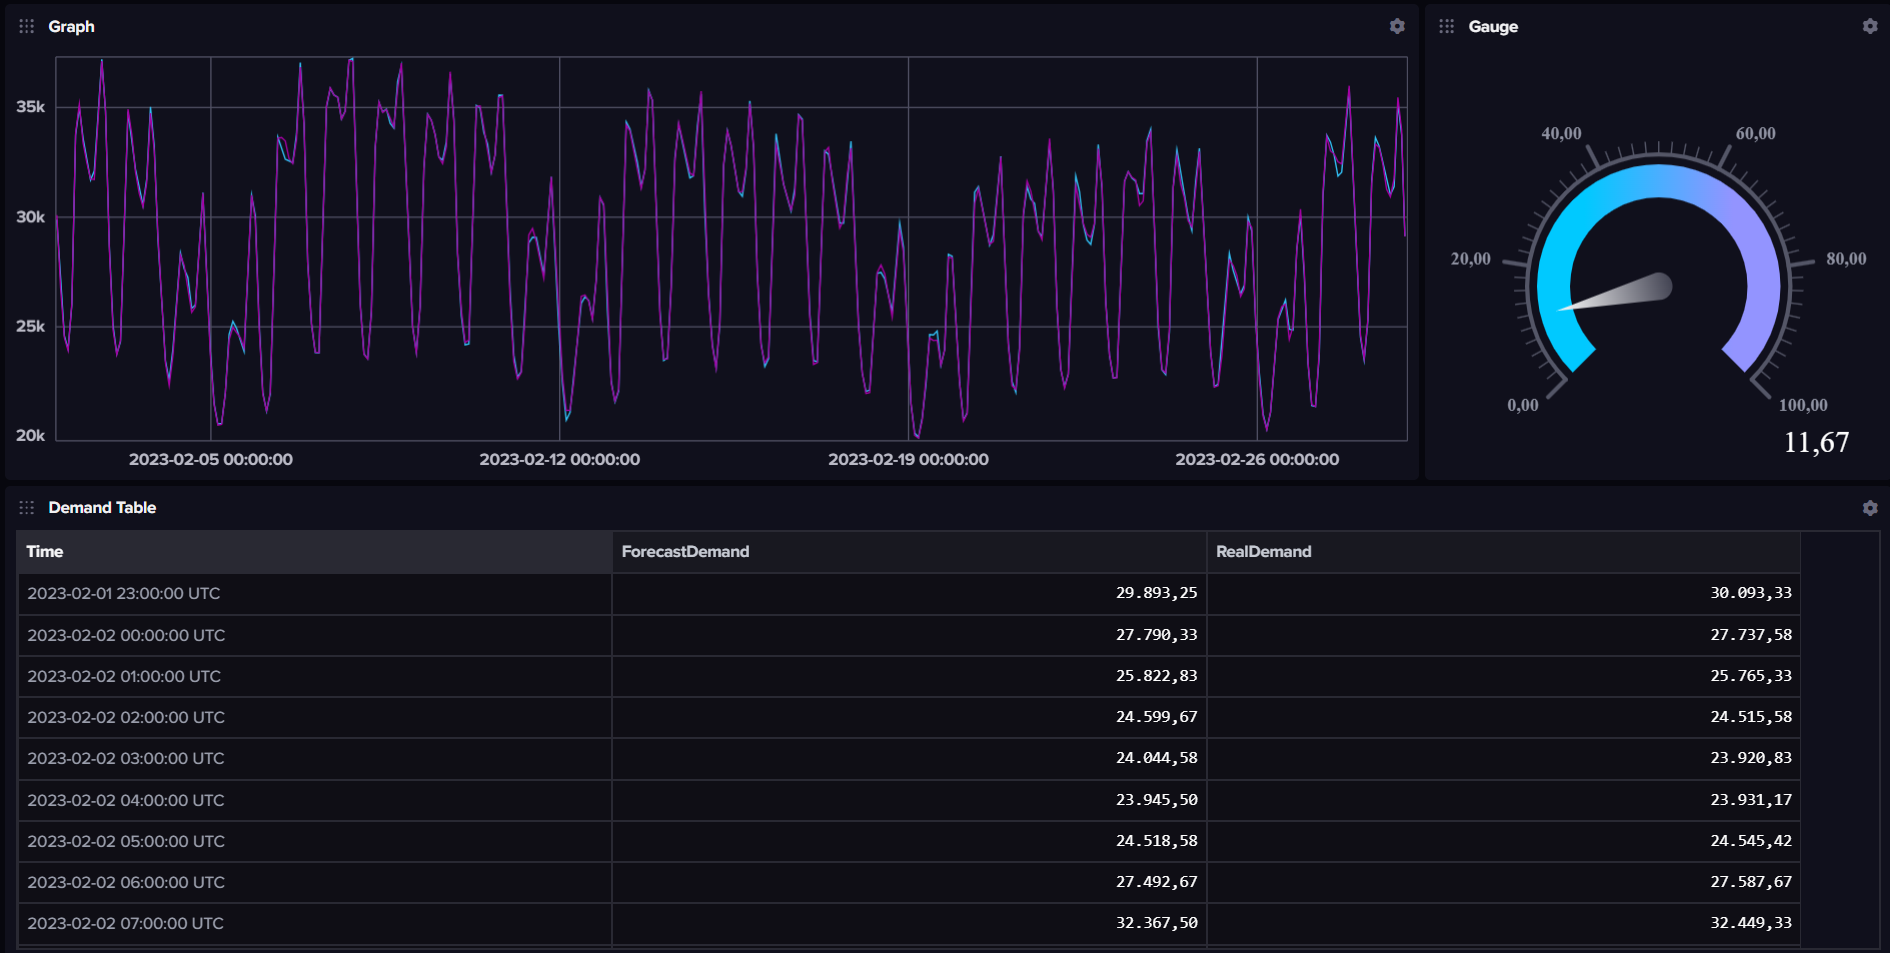
Code to generate Gauge: 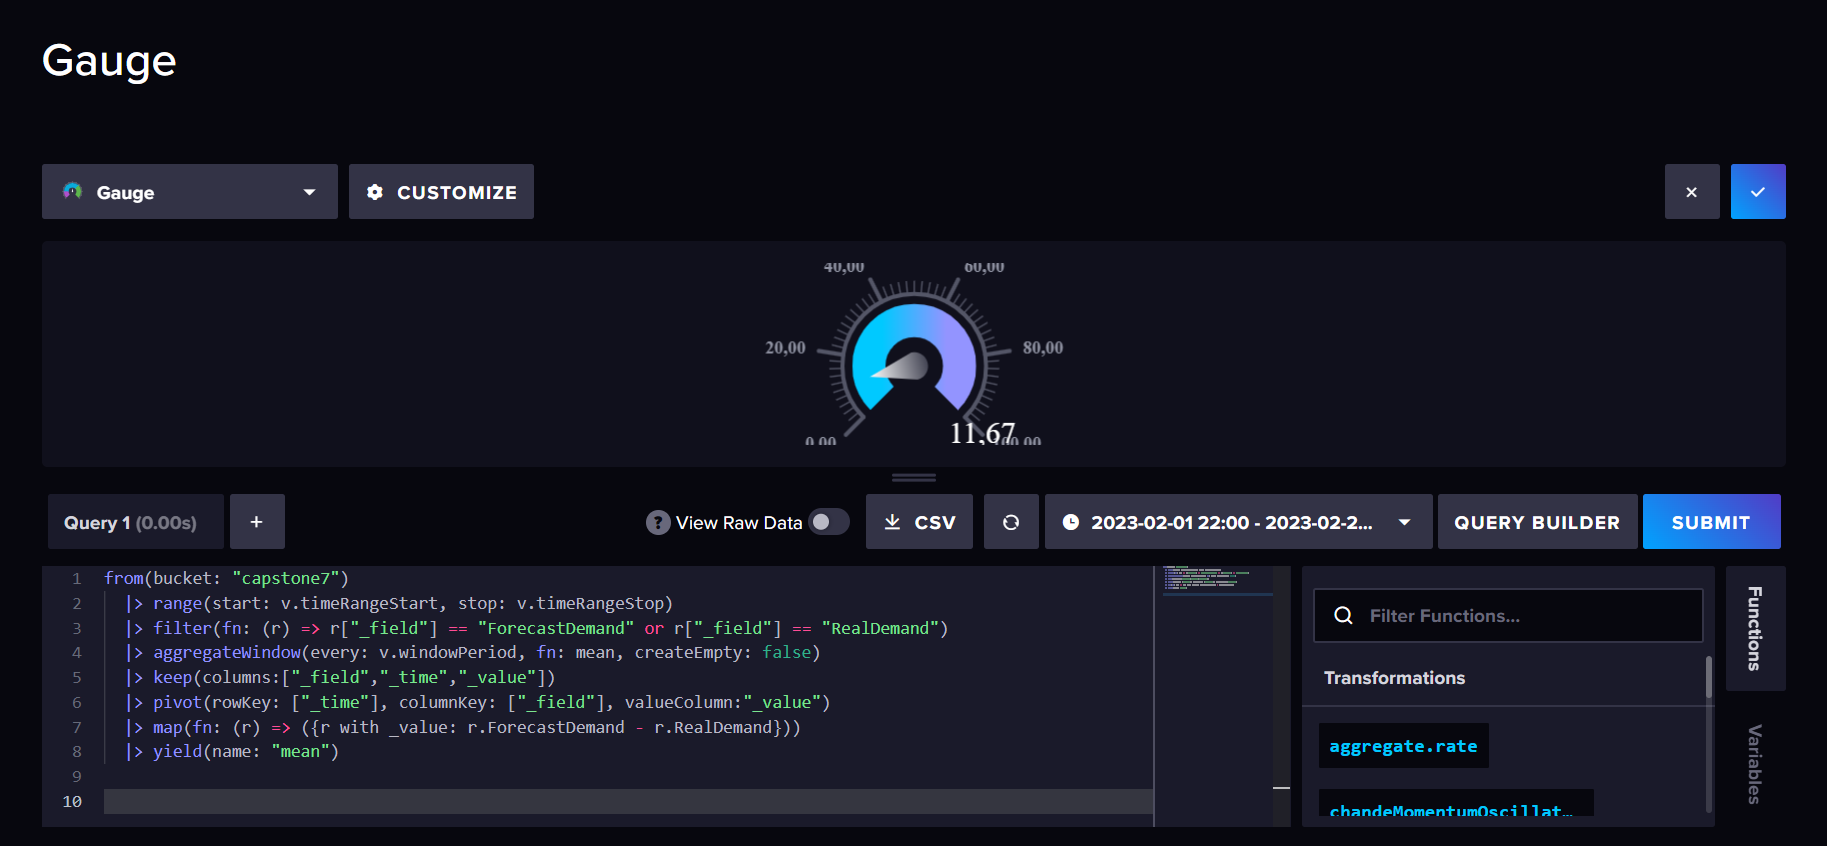
Code to generate the table: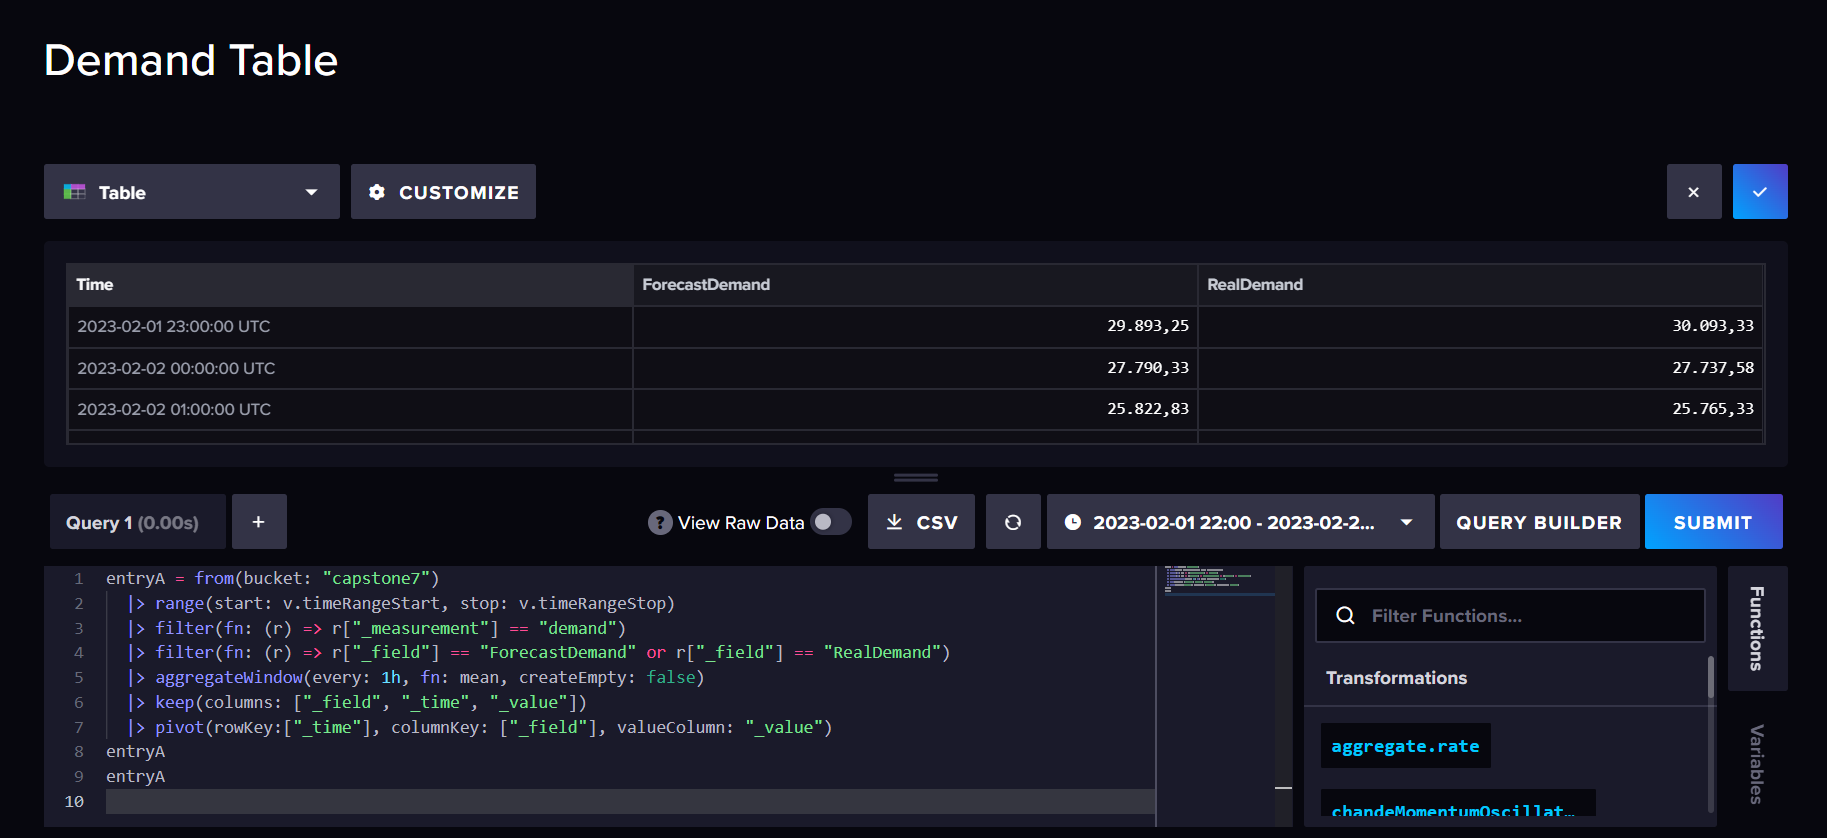

<div style="text-align: right"><font size=4> <i class="fa fa-check-square-o" aria-hidden="true" style="color:#00586D"></i></font></div>

--- 

Once these tasks are completed, we now have the prototype of our continuous electricity demand data ingestion system. As long as you leave the previous cell running with the ingestion, the data will continue to be updated in the system. If you have to stop it, when you run it again, the process will ingest all the days remaining up to the current moment, so you can leave the capstone and continue it at another time without any problem.



<div style="text-align: right"> <font size=6><i class="fa fa-coffee" aria-hidden="true" style="color:#00586D"></i> </font></div>